Modified version of https://github.com/maticvl/dataHacker/blob/master/pyTorch/011_alexNet.ipynb

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
from torchvision import datasets, transforms

import zipfile

import shutil
import os
import pandas as pd

device = ("cuda" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training

In [24]:
class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 2):
        super(AlexNet, self).__init__()

        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.linear = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2)
        )
        #Add in the next line for log normal intialization
        #self.init_bias()
    
    def init_bias(self):
        for layer in self.convolutional:
            if isinstance(layer, nn.Conv2d):
                layer.weight.log_normal_

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.convolutional(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return torch.softmax(x, 1)


In [25]:
model = AlexNet()
model = model.to(device)

In [6]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

--2024-05-13 23:03:17--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.128, 52.219.220.240, 52.219.117.168, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  17.5MB/s    in 80s     

2024-05-13 23:04:38 (17.2 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [7]:
with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [26]:
root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


In [27]:
df = pd.read_csv("list_attr_celeba.csv")
df = df[['image_id', 'Smiling']]

In [28]:
!rm -rf data
!mkdir data && mkdir data/smile && mkdir data/no_smile

In [29]:
s0 = 0
s1 = 0

num = 1500

for i, (_, i_row) in enumerate(df.iterrows()):
  if s0 < num:
    if i_row['Smiling'] == 1:
      s0 += 1
      shutil.copyfile('data_faces/img_align_celeba/' + i_row['image_id'], 'data/smile/' + i_row['image_id'])
  
  if s1 < num:
    if i_row['Smiling'] == -1:
      s1 += 1
      shutil.copyfile('data_faces/img_align_celeba/' + i_row['image_id'], 'data/no_smile/' + i_row['image_id'])
  
  if s0 == num and s1 == num:
    break

In [30]:
img_list = os.listdir('data/smile/')
img_list.extend(os.listdir('data/no_smile/'))

In [31]:
print("Images: ", len(img_list))

Images:  3000


In [32]:
!rm -rf 'data/.ipynb_checkpoints/'

In [33]:
transform = transforms.Compose([
          transforms.Resize((64, 64)),
          transforms.ToTensor()
          ])

batch_size = 64
celeba_data = datasets.ImageFolder('data', transform=transform)

In [34]:
print(celeba_data.classes)
print(len(celeba_data))

['no_smile', 'smile']
3000


In [35]:
train_set, test_set = torch.utils.data.random_split(celeba_data, [int(len(img_list) * 0.75), len(img_list) - int(len(img_list) * 0.75)])
train_data_size = len(train_set)
test_data_size = len(test_set)

In [36]:
trainLoader = torch.utils.data.DataLoader(train_set,batch_size=batch_size, shuffle=True)
testLoader  = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [37]:
print(train_data_size)
print(test_data_size)

2250
750


In [38]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [39]:
epochs = 10
train_loss = []

for epoch in range(epochs):
   
    total_train_loss = 0
    
    # training our model
    for idx, (image, label) in enumerate(trainLoader):
        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()
        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)

    print(f'Epoch: {epoch} | Train Loss: {total_train_loss}')

Epoch: 0 | Train Loss: 0.6934054245551428
Epoch: 1 | Train Loss: 0.6889112922880385
Epoch: 2 | Train Loss: 0.6568439784977171
Epoch: 3 | Train Loss: 0.5830420007308325
Epoch: 4 | Train Loss: 0.5383997476763196
Epoch: 5 | Train Loss: 0.48722198026047814
Epoch: 6 | Train Loss: 0.4813469582133823
Epoch: 7 | Train Loss: 0.4314655173155997
Epoch: 8 | Train Loss: 0.43016036848227185
Epoch: 9 | Train Loss: 0.4171392114626037


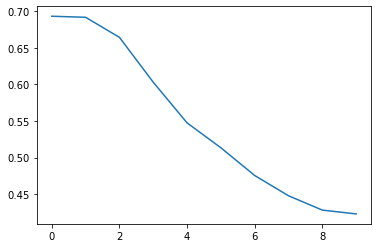

In [23]:
plt.plot(train_loss)